Time Series Data Imputation with GANs
=============

By Sohaib Errabii, Mael Lucas

Introduction
------------

This notebook is devoted to the investigation of different GAN based methods for time series imputation.


In [30]:
import random
import pandas as pd
import numpy as np
import os
from IPython.display import display
from typing import Tuple
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from datasets import UCIHARDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

In [31]:
# Root directory of datasets
root = "data"

# Rate of the missing data
miss_rate = 0.2

# Number of workers for dataloader
workers = 2

# Hidden size of GRU
hz = 64

# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.005

# Generator MSELoss multiplier
alpha = 100

Data
----

We will use the **UCI-HAR** Dataset <https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones>. 



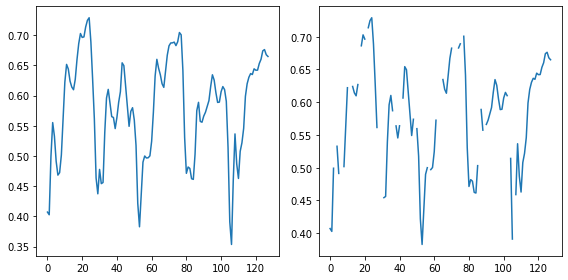

In [58]:
# Create the datasets
ucihar = UCIHARDataset(root_dir=root, download=True)
ucihar_miss = UCIHARDataset(root_dir=root, miss_rate=miss_rate)

# Create the dataloader
dataloader = DataLoader(ucihar_miss, batch_size=batch_size, num_workers=workers)

# Define UCI-HAR parameters
n_samples = len(ucihar)
time_steps = ucihar.data.shape[1]
n_features = len(ucihar.signal_types)

# Plot some signal before/after amputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ucihar.data[sample_id, :, signal_id])
axes[1].plot(ucihar_miss.data[sample_id, :, signal_id])
fig.tight_layout()

# TODO: improve data missingness simulation (something more sequential but controllable with miss_rate)

Model
--------------

We start with a simple GAN model, where the generator and discriminator are instances of `GRUBase`

In [34]:
class GRUBase(nn.Module):
    def __init__(self, sequence_length, input_size, hidden_size):
        super().__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc_out = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x, hidden):
        output, _ = self.gru(x, hidden)
        return self.fc_out(output)
    
    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


def generator_loss(
        x: Tensor, x_hat: Tensor,
        mask: Tensor, d_x: Tensor) -> Tuple[Tensor, Tensor]:
    return (nn.MSELoss()(mask * x, mask * x_hat),
           torch.mean(~mask * torch.log(torch.add(d_x, 1e-8)))
    )

In [35]:
# Generator & Discriminator
netG = GRUBase(time_steps, n_features, hz)
netD = GRUBase(time_steps, n_features, hz)

# Loss functions
criterionG = generator_loss
criterionD = nn.BCELoss()

# Optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)

Training
--------------

In [38]:
# Training Loop

# Lists to keep track of progress
lossesG = []
lossesD = []

for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader):
        # Sample random noise
        z = torch.rand(data.shape) * 0.01
        
        # Get binary mask from data, mask = 1 if observed
        mask = ~torch.isnan(data)
        
        # Combine random noise with observed data
        data = mask * torch.nan_to_num(data) + ~mask * z
        
        ###################################
        # (1) Update D: minimize BCE(M, D(G(x)))
        ###################################
        netD.zero_grad()
        
        # Generate imputed data with G
        dataG = netG(data, netG.init_hidden(data.shape[0]))
        
        # Classify imputed data with D
        data_imp = mask * data + ~mask * dataG
        probD = netD(data_imp.detach(), netD.init_hidden(data.shape[0]))
        
        # Compute loss for D
        lossD = criterionD(probD, mask.float())
        # Compute gradients for D
        lossD.backward()
        # Update D
        optimizerD.step()
        
        ###################################
        # (2) Update G: minimize MSE(M * x, M * G(x)) - (1 - M) * log(D(G(x))
        ###################################
        netG.zero_grad()
        
        # Classify imputed data once more since D got updated
        probD = netD(data_imp, netD.init_hidden(data.shape[0]))
                
        # Compute loss for G
        loss_rec, loss_adv = criterionG(data, dataG, mask, probD)
        lossG = alpha * loss_rec - loss_adv
        # Compute gradients for G
        lossG.backward()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t"
                f"LossD: {lossD.item():04f}\tLossG_rec: {loss_rec.item():04f}"
                f"\tLossG_adv: {-loss_adv.item():04f}"
            )

        # Save Losses for plotting later
        lossesG.append(lossG.item())
        lossesD.append(lossD.item())

[0/20][0/58]	LossD: 0.656494	LossG_rec: 0.006922	LossG_adv: 0.117976
[0/20][50/58]	LossD: 0.501690	LossG_rec: 0.004327	LossG_adv: 0.044386
[1/20][0/58]	LossD: 0.500017	LossG_rec: 0.002534	LossG_adv: 0.045155
[1/20][50/58]	LossD: 0.501417	LossG_rec: 0.003798	LossG_adv: 0.044741
[2/20][0/58]	LossD: 0.499814	LossG_rec: 0.002277	LossG_adv: 0.044861
[2/20][50/58]	LossD: 0.501038	LossG_rec: 0.002646	LossG_adv: 0.044813
[3/20][0/58]	LossD: 0.499334	LossG_rec: 0.001849	LossG_adv: 0.044938
[3/20][50/58]	LossD: 0.498027	LossG_rec: 0.001766	LossG_adv: 0.045388
[4/20][0/58]	LossD: 0.495489	LossG_rec: 0.001364	LossG_adv: 0.045856
[4/20][50/58]	LossD: 0.477261	LossG_rec: 0.001116	LossG_adv: 0.050010
[5/20][0/58]	LossD: 0.471703	LossG_rec: 0.000956	LossG_adv: 0.051909
[5/20][50/58]	LossD: 0.436236	LossG_rec: 0.000739	LossG_adv: 0.065148
[6/20][0/58]	LossD: 0.429330	LossG_rec: 0.000724	LossG_adv: 0.066053
[6/20][50/58]	LossD: 0.403116	LossG_rec: 0.000492	LossG_adv: 0.076702
[7/20][0/58]	LossD: 0.39854

Results
--------------

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

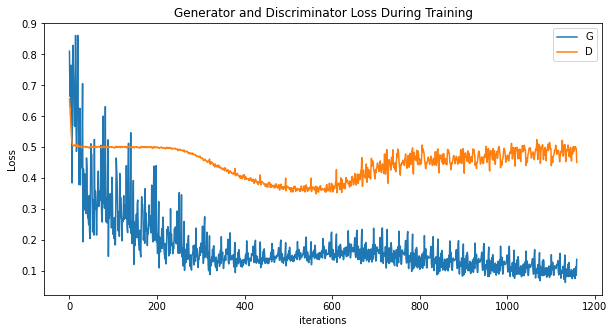

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossesG,label="G")
plt.plot(lossesD,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Imputation error**

Since we have the real observed data, we can evaluate the quality
of the imputation with the mean square error.

In [65]:
def imputation_mse(x: Tensor, x_hat: Tensor, mask: Tensor) -> Tuple[float, ...]:
    """Compute the mean square error of the imputation.

    Args:
        x (Tensor): The complete data.
        x_hat (Tensor): The imputed data.
        mask (Tensor): Binary mask where 1 means observed and 0 missing/imputed.

    Returns:
        mse_mean, mse_std, mse_val (Tuple[float, ...]): the mean square error
            between observed and imputed value, their mean and std. The mean
            and standard deviation are computed along the second dimension.
    """
    x_std, x_mean = torch.std_mean(x, 1)
    x_hat_std, x_hat_mean = torch.std_mean(x_hat, 1)

    mse_mean = nn.MSELoss()(x_mean, x_hat_mean).item()
    mse_std = nn.MSELoss()(x_std, x_hat_std).item()
    mse_val = nn.MSELoss()(~mask * x, ~mask * x_hat).item()
    return mse_mean, mse_std, mse_val

MSE of values: 0.001011
MSE of signal mean: 0.000116
MSE of signal std: 0.000240


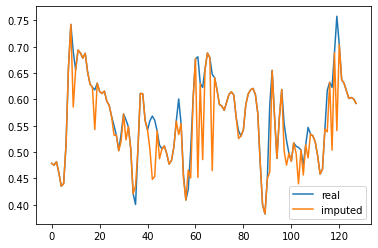

In [73]:
# We impute the whole dataset at once
with torch.no_grad():
    # Complete data
    x_complete = ucihar.data

    # Impute the missing data
    x_miss = ucihar_miss.data
    z = torch.rand(x_miss.shape) * 0.01
    mask = ~torch.isnan(x_miss)
    x_noised = mask * torch.nan_to_num(x_miss) + ~mask * z
    xG = netG(x_noised, netG.init_hidden(x_noised.shape[0]))
    x_hat = mask * x_noised + ~mask * xG

    # MSE
    mean, std, val = imputation_mse(x_complete, x_hat, mask)
    print(
        f"MSE of values: {val:04f}\nMSE of signal mean: {mean:04f}\n"
        f"MSE of signal std: {std:04f}"
    )

    # Plot some signal before/after imputation
    signal_id = random.randrange(n_features)
    sample_id = random.randrange(n_samples)
    plt.plot(x_complete[sample_id, :, signal_id], label="real")
    plt.plot(x_hat[sample_id, :, signal_id], label="imputed")
    plt.legend()